# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost</p></div> 

- **Model** 
    - Train-Test Split
    - Cross Validation
- **Hypertuning**
     - Optuna
     - Trade-Off Variance/Bias
- **Feature Importance**     
    - Enssemble Method
    - SHAP

In [1]:
%%capture
%run part03_preparation.ipynb

In [12]:
X.shape, y.shape

((119389, 14), (119389,))

In [13]:
# Machine Learning Models
from xgboost import XGBClassifier, plot_importance

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Feature Importance Tools
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
import shap
from shap import plots

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((95511, 14), (95511,), (23878, 14), (23878,))

In [15]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [16]:
def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC']) 
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    #print(f"AUC: {auc:.4f}\n\n")     
   
    return y_prob, auc

In [17]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

In [18]:
xgb = XGBClassifier(random_state=RANDOM_SEED)

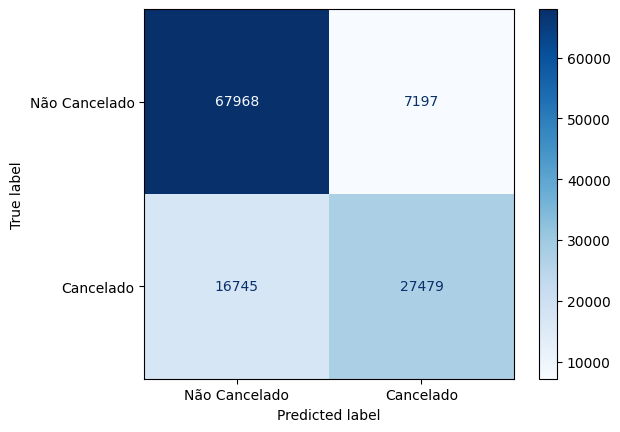

Score: 
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     75165
           1       0.79      0.62      0.70     44224

    accuracy                           0.80    119389
   macro avg       0.80      0.76      0.77    119389
weighted avg       0.80      0.80      0.79    119389



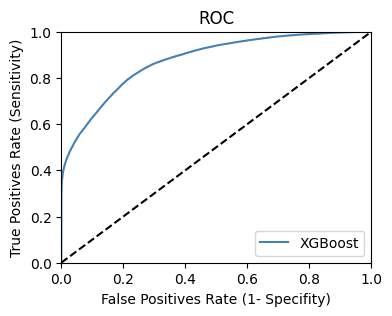

,value,std
fit_time,1.002509,0.052191
score_time,0.032176,0.002431
test_accuracy,0.799462,0.002214
train_accuracy,0.813031,0.001439
test_precision,0.792496,0.004767
train_precision,0.815608,0.002291
test_recall,0.621360,0.007283
train_recall,0.639935,0.004353
test_f1,0.696533,0.004408
train_f1,0.717160,0.002800


In [20]:
xgb_y_prob, xgb_y_pred = CVS(xgb,X,y,'XGBoost')

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

In [22]:
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

1.7

In [27]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),  
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 150, step=50),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 0.9),     
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),
        #'early_stopping_rounds':100,        
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=False) #random_state=RANDOM_SEED
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return f1_score(y,y_pred)

In [28]:
study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=50) 

trial = study.best_trial

[I 2023-06-10 21:05:40,147] A new study created in memory with name: no-name-3e06566e-59b2-4fcd-953f-1d4c0925be09
[I 2023-06-10 21:05:45,216] Trial 0 finished with value: 0.34440623019295313 and parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.0026053755188103593, 'n_estimators': 50, 'alpha': 0.6911847343478275, 'lambda': 4.0718389105964854e-07, 'min_child_weight': 1, 'colsample_bytree': 0.8805499650026326, 'scale_pos_weight': 1, 'seed': 42}. Best is trial 0 with value: 0.34440623019295313.
[I 2023-06-10 21:05:48,363] Trial 1 finished with value: 0.43276530233051974 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.01137772781686011, 'n_estimators': 150, 'alpha': 0.00036425401091772083, 'lambda': 1.8694428603516337e-07, 'min_child_weight': 3, 'colsample_bytree': 0.41132662320203217, 'scale_pos_weight': 1.7, 'seed': 42}. Best is trial 1 wi

[I 2023-06-10 21:07:31,462] Trial 18 finished with value: 0.43489087743450616 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.00345729404375149, 'n_estimators': 150, 'alpha': 2.6931551242019203e-07, 'lambda': 9.714125517143958e-08, 'min_child_weight': 3, 'colsample_bytree': 0.5975228928922252, 'scale_pos_weight': 1.7, 'seed': 42}. Best is trial 10 with value: 0.4398452097734304.
[I 2023-06-10 21:07:34,748] Trial 19 finished with value: 0.42435246170784 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.0016818846440555578, 'n_estimators': 100, 'alpha': 2.7209219033743183e-06, 'lambda': 1.0953423689491708e-06, 'min_child_weight': 5, 'colsample_bytree': 0.6836194898758299, 'scale_pos_weight': 1.7, 'seed': 42}. Best is trial 10 with value: 0.4398452097734304.
[I 2023-06-10 21:07:38,366] Trial 20 finished with value: 0.4108135315953944 a

[I 2023-06-10 21:09:13,397] Trial 36 finished with value: 0.41706250392349703 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.001234551802311787, 'n_estimators': 100, 'alpha': 3.551899942096772e-08, 'lambda': 8.139080612287465e-08, 'min_child_weight': 3, 'colsample_bytree': 0.4486673978921832, 'scale_pos_weight': 1.7, 'seed': 42}. Best is trial 22 with value: 0.44127598858540557.
[I 2023-06-10 21:09:18,674] Trial 37 finished with value: 0.4048166486648344 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 9, 'learning_rate': 0.005790279826269946, 'n_estimators': 150, 'alpha': 1.0799106321976684e-08, 'lambda': 3.086842696995467e-07, 'min_child_weight': 5, 'colsample_bytree': 0.48589409067002065, 'scale_pos_weight': 1.7, 'seed': 42}. Best is trial 22 with value: 0.44127598858540557.
[I 2023-06-10 21:09:22,666] Trial 38 finished with value: 0.37294683728063

In [29]:
# Print the result
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

Best score: 0.44127598858540557

Optimized parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.0011470723804591913, 'n_estimators': 150, 'alpha': 1.0371899177916489e-08, 'lambda': 3.015862707659298e-08, 'min_child_weight': 3, 'colsample_bytree': 0.5365999849973491, 'scale_pos_weight': 1.7, 'seed': 42}



In [32]:
xgb_best_params

{'objective': 'binary:logistic',
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 6,
 'learning_rate': 0.0011470723804591913,
 'n_estimators': 150,
 'alpha': 1.0371899177916489e-08,
 'lambda': 3.015862707659298e-08,
 'min_child_weight': 3,
 'colsample_bytree': 0.5365999849973491,
 'scale_pos_weight': 1.7,
 'seed': 42}

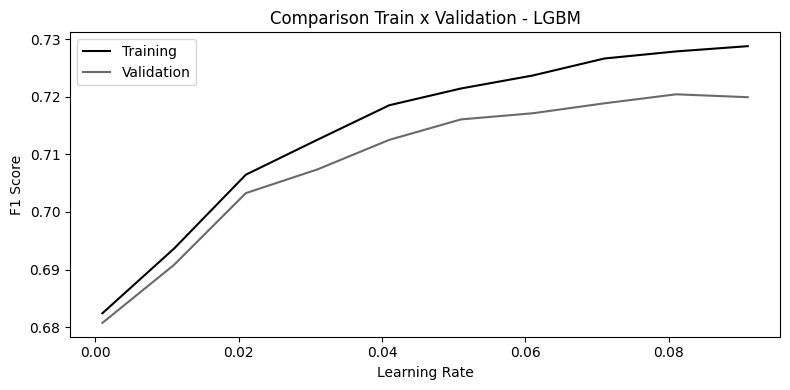

In [34]:
aux = xgb_best_params
aux.pop('learning_rate', None)

param_range = np.arange(0.001, 0.1, 0.01)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    xgb = XGBClassifier(**aux,learning_rate = i)
    xgb.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,xgb.predict(X_train)))
    val_scores.append(f1_score(y_val,xgb.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

In [ ]:
model_filename = "model_lgbm_tuned.pkl"

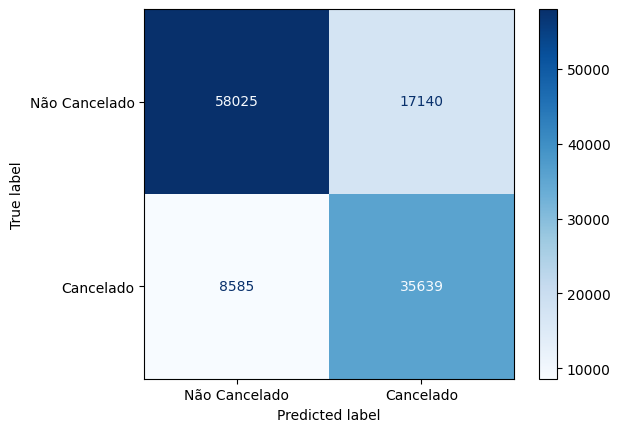

Score: 
               precision    recall  f1-score   support

           0       0.87      0.77      0.82     75165
           1       0.68      0.81      0.73     44224

    accuracy                           0.78    119389
   macro avg       0.77      0.79      0.78    119389
weighted avg       0.80      0.78      0.79    119389



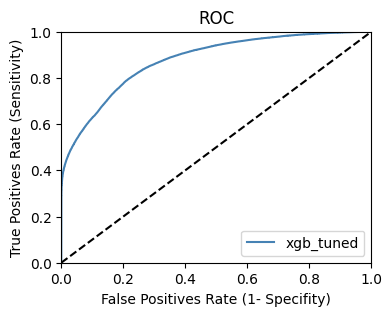

,value,std
fit_time,1.161907,0.067414
score_time,0.036229,0.000842
test_accuracy,0.784528,0.002291
train_accuracy,0.798099,0.001070
test_precision,0.675251,0.002318
train_precision,0.690388,0.001870
test_recall,0.805875,0.006815
train_recall,0.824874,0.001433
test_f1,0.734791,0.003514
train_f1,0.751661,0.000934


ValueError: not enough values to unpack (expected 3, got 2)

In [35]:
model_xgb_tuned = XGBClassifier(**xgb_best_params)
y_prob_xgb_tuned, y_pred_xgb_tuned, scores_xgb_tuned  = CVS(model_xgb_tuned,X,y,'xgb_tuned')

In [ ]:
xgb_best_params = {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.08954641832548456, 'n_estimators': 150, 'alpha': 0.044798317820219084, 'lambda': 1.3854331769012785e-05, 'min_child_weight': 1, 'colsample_bytree': 0.5179903201439937, 'scale_pos_weight': 1.696, 'seed': 42}

In [ ]:
results['xgb_prob'] = y_prob_xgb_tuned
results['xgb_pred'] = y_pred_xgb_tuned

In [ ]:
xgb_best_params = {'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 #'max_depth': 10,
 'learning_rate': 0.09971203875947736,
 'n_estimators': 150,
 'alpha': 2.957003467711026e-08,
 'lambda': 4.009830502312534e-07,
 'min_child_weight': 5,
 'colsample_bytree': 0.4584833524080041,
 'scale_pos_weight': 1.696,
 'seed': 42}


param_range = np.arange(3, 20, 1)


train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xgb = XGBClassifier(**xgb_best_params,
        max_depth = i
)
    xgb.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,xgb.predict(X_train)))
    test_scores.append(f1_score(y_val,xgb.predict(X_val)))
    

plt.subplots(1, figsize=(6,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, test_scores, label="Validation", color="dimgrey")

 
plt.title("Comparison Train x Validation - XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()    

In [ ]:
#optuna.visualization.plot_optimization_history(study)
#optuna.visualization.plot_slice(study)
#optuna.visualization.plot_param_importances(study)

In [ ]:
xgb = XGBClassifier()#**xgb_best_params
xgb.fit(X,y)
xgboost.plot_importance(xgb);

In [ ]:
# fi_xgb = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': xgb.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - XGBoost Classifier')
# sns.barplot(data=fi_xgb.head(15), x='importance', y='feature', color='SteelBlue');
# plt.show()